### **Movie Recommendation System with ALS.**

Content

*   Installing Spark

*   Loading Data

*   Spark ALS Model Selection and Evaluation

*   Model Testing

*   Inference

*   Scrapping IMDB

*   Visualizations


In [45]:
import os
import time
import math
import numpy as np
import pandas as pd
#pip install selenium
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import cv2
from bs4 import BeautifulSoup
from selenium import webdriver
import urllib.request
import sys
import re
import requests
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing Spark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.0.3-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
import findspark
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

sc = spark.sparkContext
lines = sc.textFile("spark-2.4.4-bin-hadoop2.7/README.md")


In [ ]:
input = sc.textFile("spark-2.4.4-bin-hadoop2.7/*.md")

In [ ]:
!cp "/content/drive/My Drive/data/ratings.csv" "ratings.csv"


### Loading Data

In [ ]:
df = spark.read.csv('ratings.csv',inferSchema=True, header=True)
df

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [ ]:
movies = spark.read.load(os.path.join('/content/drive/MyDrive/data/', 'movies.csv'), format='csv', header=True, inferSchema=True)


Now let's read the data again in RDD format and convert it to the form of (user, item, rating) tuples.

In [ ]:
movie_rating = sc.textFile('ratings.csv')
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
rating_data.take(5)

[(1, 307, 3.5), (1, 481, 3.5), (1, 1091, 1.5), (1, 1257, 4.5), (1, 1449, 4.5)]

Splitting the data into training, validation and testing sets using a 6/2/2 ratio.

In [ ]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
train.cache()
validation.cache()
test.cache()

PythonRDD[31] at RDD at PythonRDD.scala:53

## ALS model selection and evaluation


In order to find the most optimal parameters for ALS model (number of iterations (num_iters), regularization parameter (reg_param) and ranks) I will use a grid search. 

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,   
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print(f'\nThe best model has {best_rank} latent factors and regularization = {best_regularization}')

    return best_model


In [23]:
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and selecting the best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.8781162712877985
8 latent factors and regularization = 0.01: validation RMSE is 0.8510031343247564
8 latent factors and regularization = 0.05: validation RMSE is 0.824954562926557
8 latent factors and regularization = 0.1: validation RMSE is 0.824644675945038
8 latent factors and regularization = 0.2: validation RMSE is 0.8664524235392923
10 latent factors and regularization = 0.001: validation RMSE is 0.8849061737726851
10 latent factors and regularization = 0.01: validation RMSE is 0.8547110311493881
10 latent factors and regularization = 0.05: validation RMSE is 0.8172521217217741
10 latent factors and regularization = 0.1: validation RMSE is 0.8182213086240143
10 latent factors and regularization = 0.2: validation RMSE is 0.8652185670602972
12 latent factors and regularization = 0.001: validation RMSE is 0.8976672423957611
12 latent factors and regularization = 0.01: validation RMSE is 0.8619437067836601
12 latent fa

### Model Testing

Checking the testing error using out-of-sample data.

In [33]:
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8145


### Inference

Here we have two functions: get_fav_movies() and getRecs(). The first one prints the movies with highest ratings for the corresponding user and the second one shows the recommended movies by our model.

In [34]:
def get_fav_movies(user_id, data, movies):
  movie_ids = data.filter(lambda x: x[0]==user_id)\
    .map(lambda p: p[1]).collect()
  return movies.filter(movies.movieId.isin(movie_ids)) \
                      .select('title') \
                      .rdd \
                      .map(lambda r: r[0]) \
                      .collect() 
  

In [37]:
favlist = get_fav_movies(5,test,movies)
favlist

['Cold Comfort Farm (1995)',
 'Trainspotting (1996)',
 'L.A. Confidential (1997)',
 'Fight Club (1999)',
 'Any Given Sunday (1999)',
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 'The Machinist (2004)',
 'Woodsman, The (2004)',
 'Sin City (2005)',
 'Little Miss Sunshine (2006)',
 'Stranger than Fiction (2006)',
 "Pan's Labyrinth (Laberinto del fauno, El) (2006)",
 'Departed, The (2006)',
 'Prestige, The (2006)',
 'Blood Diamond (2006)',
 'Letters from Iwo Jima (2006)',
 'Into the Wild (2007)',
 'Gone Baby Gone (2007)',
 'American Gangster (2007)']

In [38]:
def getRecs(user_id, data, movies,topk):
  movieId_list = data.filter(lambda x: x[0]==user_id)\
    .map(lambda p: p[1]).collect()
  infer_data = movies.rdd.map(lambda r: r[0])\
      .distinct() \
      .filter(lambda x: x not in movieId_list)\
      .map(lambda r: (user_id, r))
  predictions = final_model2.predictAll(infer_data).map(lambda r: ((r[0], r[1]), r[2]))
  topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(topk)
  topn_ids = [r[0][1] for r in topn_rows]
  return movies.filter(movies.movieId.isin(topn_ids)) \
                      .select('title') \
                      .rdd \
                      .map(lambda r: r[0]) \
                      .collect()  


In [39]:
movielist = getRecs(5,test,movies,10)
movielist

['Konopielka (1982)',
 'Devil to Pay!, The (1930)',
 'Connections (1978)',
 'Hamoun (1990)',
 'Antarctica (1983)',
 'Lagerfeld Confidential (2007)',
 'Life Even Looks Like a Party (2009)',
 'Love Is Blind (2013)',
 'Seeing Red: Stories of American Communists (1983)',
 'The Story of the Voyages (1983)']

### Scrapping IMDB

In [40]:
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:14 http://security.ubuntu.c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: use options instead of chrome_options
  # Remove the CWD from sys.path while we load stuff.


In [58]:
def getposters(lst): 
  imagelist=[]
  #getting links for the desired movies
  for link in lst:
      template = 'https://www.imdb.com/find?q={}&ref_=nv_sr_sm'
      link = link.replace(' ', '+')
      url = template.format(link)
      driver.get(url)
      page_html = driver.page_source
      page_soup = BeautifulSoup(page_html, 'lxml')
      table = page_soup.find('tbody')
      if table is not None:
      #print(table)
        rows = table.find('tr')
        name_div = rows.find('td', {"class": "primary_photo"})
        name_a = name_div.find('a', href= True)
        name = name_a['href']
        driver.get('https://www.imdb.com' + name)
        x=str('https://www.imdb.com' + name)
        imagelist.append(x)
  print(imagelist)

  #createing a folder Output to save the images in there
  dirName = "Output"
  os.chdir('/content/drive/MyDrive/')

  if not os.path.exists(dirName):
      !mkdir Output
      print("Directory " , dirName ,  " Created ")
  else:    
      print("Directory " , dirName ,  " already exists")
  #getting posters from links and donwloading them
  for url in imagelist:
      driver.get(url)
      page_html = driver.page_source
      page_soup = BeautifulSoup(page_html, 'lxml')
      posterdiv = page_soup.find("div", {"class": "ipc-media ipc-media--poster-27x40 ipc-image-media-ratio--poster-27x40 ipc-media--baseAlt ipc-media--poster-l ipc-poster__poster-image ipc-media__img"})
      
      img = posterdiv.find("img",src=True)
      image_link=(img["src"])
      result =  re.split(r'/', url)
      st = result[4]
      img_nk = requests.get(image_link)
      file = open(f'/content/drive/MyDrive/Output/nkar{st}.jpg','wb')
      file.write(img_nk.content)
      file.close()



In [59]:
getposters(favlist[:10]) #we want top 10 favorite movies

['https://www.imdb.com/title/tt0112701/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0117951/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0119488/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0137523/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0146838/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0211915/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0361862/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0361127/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0401792/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0449059/?ref_=fn_al_tt_1']
Directory  Output  Created 


### Visualizations of Top 10 Favorite Movies

Cold Comfort Farm (1995)
Trainspotting (1996)
L.A. Confidential (1997)
Fight Club (1999)
Any Given Sunday (1999)
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
The Machinist (2004)
Woodsman, The (2004)
Sin City (2005)
Little Miss Sunshine (2006)


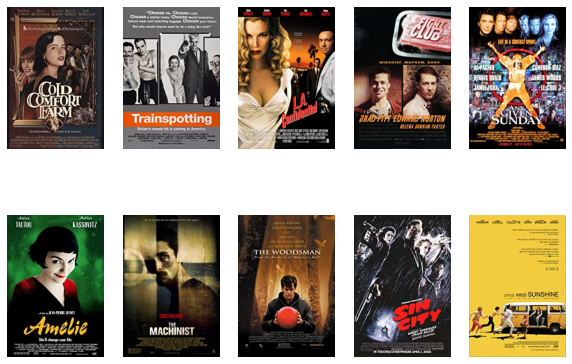

In [60]:
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 5

# get data file names
path =r'/content/drive/MyDrive/Output'
#path =r'/Output'
for score in favlist:
    print(score)
filenames = glob.glob(path + "/*.jpg")
for n,i in enumerate(filenames): 
    image1 = cv2.imread(i)
    rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, n+1)
    plt.imshow(rgb, cmap = plt.cm.Spectral)
    plt.axis('off')


In [61]:
#deleting the folder Output
os.chdir('/content/drive/MyDrive')
!rm -rf Output


In [62]:
getposters(movielist) 

['https://www.imdb.com/title/tt0085807/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0020821/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0078588/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0099729/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0085991/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0809439/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt2534648/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0086273/?ref_=fn_al_tt_1', 'https://www.imdb.com/title/tt0141830/?ref_=fn_al_tt_1']
Directory  Output  Created 


### Visualizations of Top 10 Recommended movies

Konopielka (1982)
Devil to Pay!, The (1930)
Connections (1978)
Hamoun (1990)
Antarctica (1983)
Lagerfeld Confidential (2007)
Life Even Looks Like a Party (2009)
Love Is Blind (2013)
Seeing Red: Stories of American Communists (1983)
The Story of the Voyages (1983)


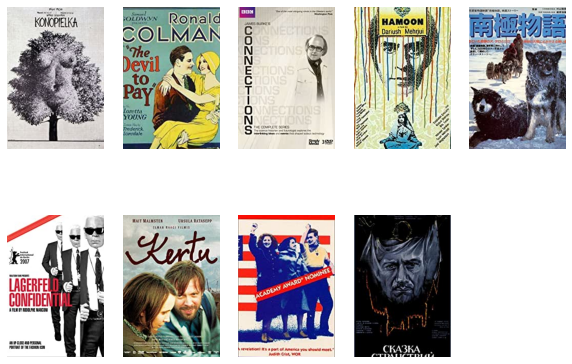

In [63]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 5

# get data file names
path =r'/content/drive/MyDrive/Output'
for score in movielist:
    print(score)
filenames = glob.glob(path + "/*.jpg")

for n,i in enumerate(filenames): 
    image1 = cv2.imread(i)
    rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, n+1)
    plt.imshow(rgb, cmap = plt.cm.Spectral)
    plt.axis('off')


In [64]:
#deleting the folder Output
os.chdir('/content/drive/MyDrive')
!rm -rf Output
